In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import QuantileTransformer
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_curve, f1_score

#some models
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

In [169]:
offers_classed=pd.read_pickle("final_table.pkl")

Calling the table off holding all the data 'offers_classed'

In [170]:
offers_classed.head()

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,bogo,discount,informational,age,became_member_on,income,female,male,other
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,False,False,True,33,1492732800000000000,72000.0,False,True,False
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,False,False,True,33,1492732800000000000,72000.0,False,True,False
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,True,False,False,33,1492732800000000000,72000.0,False,True,False
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,False,True,False,33,1492732800000000000,72000.0,False,True,False
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,False,True,False,33,1492732800000000000,72000.0,False,True,False


In [171]:
labels=offers_classed['successful_offer'].values
print(len(labels))

66501


In [172]:
features_df=offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other'])

features = features_df.values

print(len(features))

66501


In [173]:
labels

array([1., 1., 0., ..., 1., 0., 0.])

In [174]:
features

array([[0.0, 0.0, 3.0, ..., False, True, False],
       [0.0, 0.0, 4.0, ..., False, True, False],
       [5.0, 5.0, 5.0, ..., False, True, False],
       ...,
       [2.0, 10.0, 7.0, ..., True, False, False],
       [5.0, 5.0, 7.0, ..., True, False, False],
       [2.0, 10.0, 7.0, ..., True, False, False]], dtype=object)

I will use a quantile transformer to scale all my features. It is robust at handling outliers and skewed data.

In [175]:
def scale_split(features,labels):
    
    #split the features and labels into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.85, random_state=40)

    #fit and transform scaling on training data
    scaler=QuantileTransformer()
    
    #scale the features separately so there is no data leak between the training set and test set
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [176]:
features_train, features_test, labels_train, labels_test=scale_split(features, labels)
features_train[0]

array([0.30530531, 0.7002002 , 1.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.51451451,
       0.2992993 , 0.94644645, 1.        , 0.        , 0.        ])

In [177]:
print('the size of the train set is: {}.'.format(len(features_train)))
print('the size of the test set is: {}.'.format(len(features_test)))

the size of the train set is: 56525.
the size of the test set is: 9976.


<font size=4>Some initial basic models to see how good they are at predicting<font/>

Decision Tree Classifier with default parameters

In [178]:
def classifyDecisionTree(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = DecisionTreeClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

f1-score for unsuccessful offers is quite good. But a score of just under 0.6 for successful offers is lower than I would like.

              precision    recall  f1-score   support

unsuccessful     0.6968    0.7108    0.7037      5677
  successful     0.6076    0.5915    0.5995      4299

    accuracy                         0.6594      9976
   macro avg     0.6522    0.6511    0.6516      9976
weighted avg     0.6584    0.6594    0.6588      9976

CPU times: user 431 ms, sys: 31.7 ms, total: 463 ms
Wall time: 412 ms


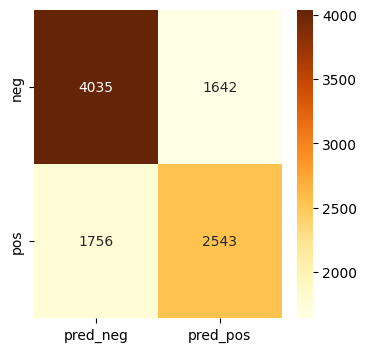

In [179]:
%%time
clf = classifyDecisionTree(features_train, labels_train, features_test, labels_test)


Adaboost with default params

In [180]:
def classifyAdaBoost(features_train, labels_train, features_test, labels_test):
    
    # Create the classifier using SAMME algorithm
    clf = AdaBoostClassifier(algorithm='SAMME', random_state=40)
    
    # Fit the training data
    clf.fit(features_train, labels_train)
    
    # Predict the testing labels using the testing features
    pred = clf.predict(features_test)
    
    # Evaluate the model's performance
    print(classification_report(labels_test, pred, digits=4, target_names=['unsuccessful', 'successful'], output_dict=False))
    
    # Print the confusion matrix
    con_mat = pd.DataFrame(confusion_matrix(labels_test, pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize=(4, 4))
    sn.heatmap(con_mat, annot=True, cmap='YlOrBr', fmt='g')

    return clf

the f1 score for adaboost is better than the decision tree for unsuccessful offers but performs a bit worse for successful offers.

              precision    recall  f1-score   support

unsuccessful     0.6838    0.8034    0.7388      5677
  successful     0.6624    0.5094    0.5759      4299

    accuracy                         0.6767      9976
   macro avg     0.6731    0.6564    0.6574      9976
weighted avg     0.6746    0.6767    0.6686      9976

CPU times: user 1.5 s, sys: 142 ms, total: 1.65 s
Wall time: 1.39 s


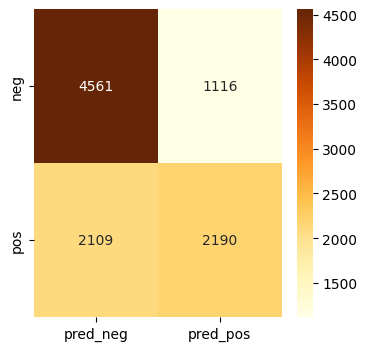

In [181]:
%%time
clf = classifyAdaBoost(features_train, labels_train, features_test, labels_test)

Random Forest with default params

In [182]:

def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    # Create the classifier
    clf = RandomForestClassifier(random_state=40)
    
    # Fit the training data
    clf.fit(features_train, labels_train)
    
    # Predict the testing labels using the testing features
    pred = clf.predict(features_test)
    
    # Print the classification report
    print(classification_report(labels_test, pred, digits=4, target_names=['unsuccessful', 'successful'], output_dict=False))
    
    # Print the confusion matrix
    con_mat = pd.DataFrame(confusion_matrix(labels_test, pred), columns=['Predicted Negative', 'Predicted Positive'], index=['Negative', 'Positive'])
    
    plt.figure(figsize=(5, 5))  # Adjusted figure size
    sn.heatmap(con_mat, annot=True, cmap='YlOrBr', fmt='g',
               annot_kws={'size': 16},  # Increase annotation size
               xticklabels=['Negative', 'Positive'],  # Custom x-axis labels
               yticklabels=['Negative', 'Positive'],  # Custom y-axis labels
               cbar=True)  # Optional: Remove color bar for simplicity
    
    # Adjust label sizes
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return clf


The default random forest classifer performs comfortably better than the other two for successful offers.

              precision    recall  f1-score   support

unsuccessful     0.7222    0.7634    0.7423      5677
  successful     0.6621    0.6122    0.6362      4299

    accuracy                         0.6983      9976
   macro avg     0.6922    0.6878    0.6892      9976
weighted avg     0.6963    0.6983    0.6966      9976



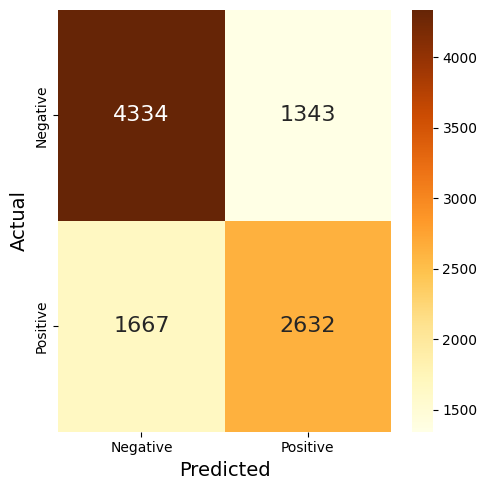

CPU times: user 6.31 s, sys: 299 ms, total: 6.61 s
Wall time: 6.22 s


In [183]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

Feature Importance

In [184]:
#resetting feature_df

features_df=offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other'])

Create a dictionary between feature names and the feature importance within the classifier.

In [185]:
dict = {}
for A, B in zip(features_df.columns.values, clf.feature_importances_):
    dict[A] = B

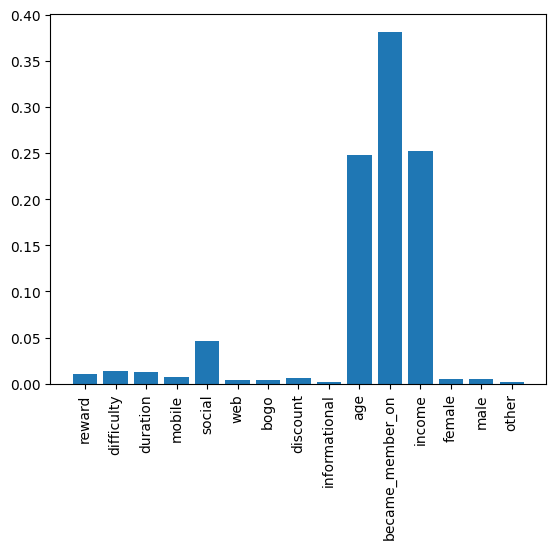

In [186]:
names = list(dict.keys())
values = list(dict.values())

plt.bar(range(len(dict)), values, tick_label=names)
plt.xticks(rotation=90)
plt.show()

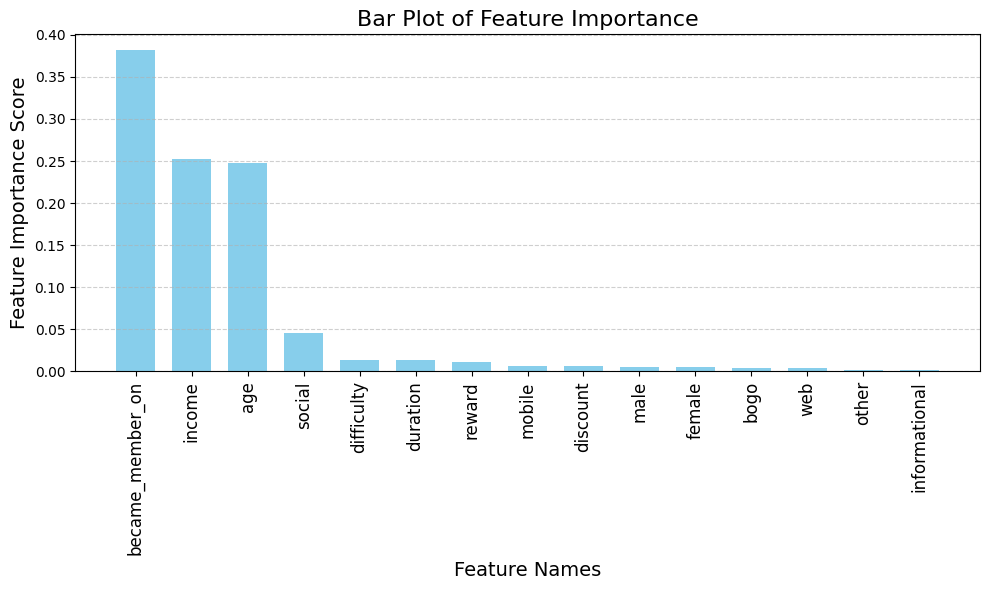

In [187]:
import matplotlib.pyplot as plt

# Assuming 'dict' is already defined
names = list(dict.keys())
values = list(dict.values())

# Sort the values in descending order along with their corresponding names
sorted_names_values = sorted(zip(names, values), key=lambda x: x[1], reverse=True)
sorted_names, sorted_values = zip(*sorted_names_values)

# Create a bar plot with improved aesthetics
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(sorted_values)), sorted_values, tick_label=sorted_names, color='skyblue', width=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# Add labels and title
ax.set_xlabel('Feature Names', fontsize=14)
ax.set_ylabel('Feature Importance Score', fontsize=14)
ax.set_title('Bar Plot of Feature Importance', fontsize=16)

# Add gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


Naive Bayes 

In [188]:
def classifyGaussianNB(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = GaussianNB()
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

very good positive recall compared to the others

              precision    recall  f1-score   support

unsuccessful     0.7090    0.6368    0.6709      5677
  successful     0.5772    0.6548    0.6136      4299

    accuracy                         0.6445      9976
   macro avg     0.6431    0.6458    0.6422      9976
weighted avg     0.6522    0.6445    0.6462      9976

CPU times: user 190 ms, sys: 80.2 ms, total: 270 ms
Wall time: 191 ms


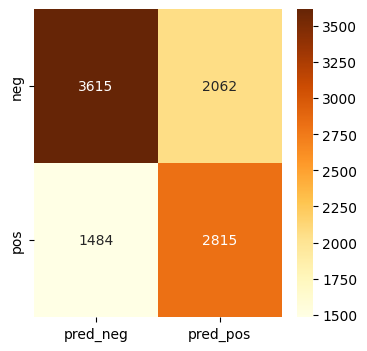

In [189]:
%%time
clf = classifyGaussianNB(features_train, labels_train, features_test, labels_test)

Support Vector Machines with default params

In [190]:
def classifySVC(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = SVC()
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True, cmap='YlOrBr', fmt='g')

    return clf

Didnt perform as well for the successful offers. But very well for unsuccessful offers.

              precision    recall  f1-score   support

unsuccessful     0.6884    0.8018    0.7408      5677
  successful     0.6656    0.5208    0.5844      4299

    accuracy                         0.6807      9976
   macro avg     0.6770    0.6613    0.6626      9976
weighted avg     0.6786    0.6807    0.6734      9976

CPU times: user 2min 37s, sys: 26.3 ms, total: 2min 37s
Wall time: 2min 36s


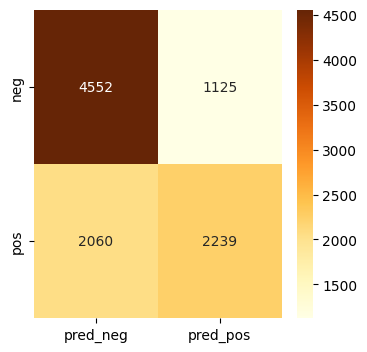

In [191]:
%%time
#commenting this for now as it takes about 3 minutes to run
clf = classifySVC(features_train, labels_train, features_test, labels_test)

<font size=5>PCA<font/>

In [192]:
scaler=QuantileTransformer()

In [193]:
features_scaled=scaler.fit_transform(features)


In [194]:
features_scaled[0]

array([0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.13763764,
       0.43043043, 0.64114114, 0.        , 1.        , 0.        ])

In [195]:
len(features_scaled)

66501

In [196]:
np.transpose(features_scaled)

array([[0.        , 0.        , 0.65665666, ..., 0.3038038 , 0.65665666,
        0.3038038 ],
       [0.        , 0.        , 0.3028028 , ..., 0.7047047 , 0.3028028 ,
        0.7047047 ],
       [0.        , 0.15165165, 0.3013013 , ..., 0.6021021 , 0.6021021 ,
        0.6021021 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [197]:
pca = PCA(n_components=15)
pca.fit(np.transpose(features_scaled))

PCA(n_components=15)

In [198]:
print(pca.explained_variance_ratio_)

[2.66936266e-01 2.04434161e-01 1.70830655e-01 1.38289254e-01
 8.52160944e-02 3.62214103e-02 2.90455494e-02 2.14990000e-02
 1.96752353e-02 1.55019599e-02 6.54938161e-03 4.43350249e-03
 1.36753102e-03 4.15128396e-32 1.98041775e-32]


A common method for determining the number of PCs to be retained is a graphical representation known as a scree plot. A Scree Plot is a simple line segment plot that shows the eigenvalues for each individual PC. It shows the eigenvalues on the y-axis and the number of factors on the x-axis. It always displays a downward curve. Most scree plots look broadly similar in shape, starting high on the left, falling rather quickly, and then flattening out at some point. This is because the first component usually explains much of the variability, the next few components explain a moderate amount, and the latter components only explain a small fraction of the overall variability. The scree plot criterion looks for the “elbow” in the curve and selects all components just before the line flattens out. (In the PCA literature, the plot is called a ‘Scree’ Plot because it often looks like a ‘scree’ slope, where rocks have fallen down and accumulated on the side of a mountain.)  
https://sanchitamangale12.medium.com/scree-plot-733ed72c8608

<function matplotlib.pyplot.show(close=None, block=None)>

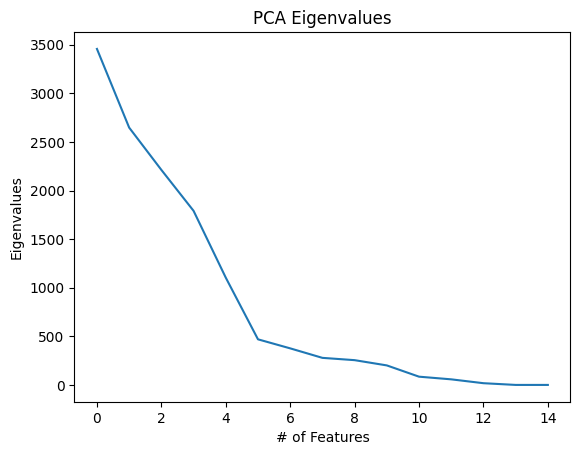

In [199]:
plt.title('PCA Eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.plot(pca.explained_variance_)
plt.show

I see an elbow at 4. I will test my model with 4 pca components and see how they perform.

<function matplotlib.pyplot.show(close=None, block=None)>

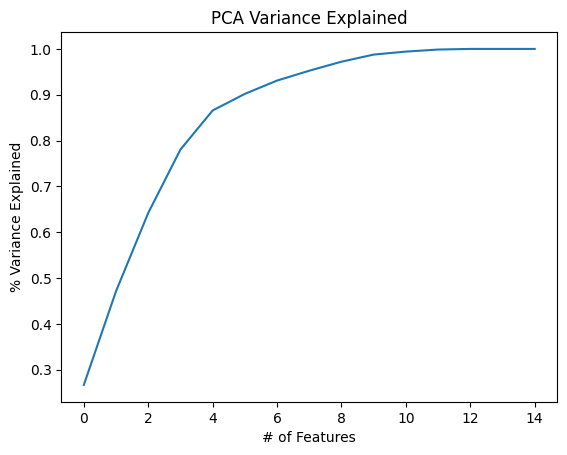

In [200]:
variance=pca.explained_variance_ratio_
var=np.cumsum(pca.explained_variance_ratio_)

plt.title('PCA Variance Explained')
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.plot(var)
plt.show

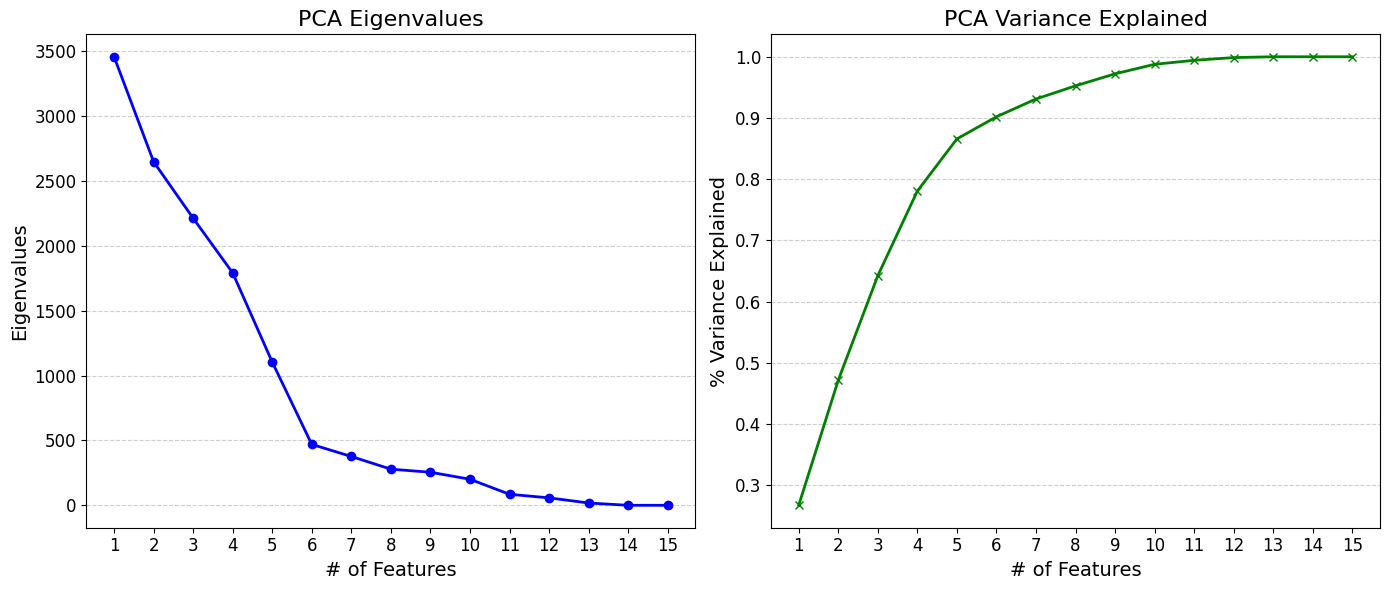

In [201]:


# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Eigenvalues
ax1.plot(pca.explained_variance_, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
ax1.set_title('PCA Eigenvalues', fontsize=16)
ax1.set_xlabel('# of Features', fontsize=14)
ax1.set_ylabel('Eigenvalues', fontsize=14)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', labelsize=12)

# Adjust x-axis labels to start from 1 instead of 0
ax1.set_xticks(np.arange(0, len(pca.explained_variance_)))  # Internal ticks still start from 0
ax1.set_xticklabels(np.arange(1, len(pca.explained_variance_) + 1))  # Labels start from 1

# Plot Variance Explained
variance = pca.explained_variance_ratio_
var = np.cumsum(variance)

ax2.plot(var, color='green', marker='x', linestyle='-', linewidth=2, markersize=6)
ax2.set_title('PCA Variance Explained', fontsize=16)
ax2.set_xlabel('# of Features', fontsize=14)
ax2.set_ylabel('% Variance Explained', fontsize=14)
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
ax2.tick_params(axis='both', labelsize=12)

# Adjust x-axis labels to start from 1 instead of 0
ax2.set_xticks(np.arange(0, len(var)))  # Internal ticks still start from 0
ax2.set_xticklabels(np.arange(1, len(var) + 1))  # Labels start from 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [202]:
print("the first 4 pca components represents {:0.2f} of the variance".format(np.cumsum(pca.explained_variance_ratio_)[5]))

the first 4 pca components represents 0.90 of the variance


In [203]:
pca = PCA(n_components=6)
pca.fit(np.transpose(features_scaled))

PCA(n_components=6)

In [204]:
pca.components_

array([[ 0.00165966,  0.00276355,  0.00577424, ...,  0.00247373,
         0.00282946,  0.00247373],
       [-0.00400084, -0.00058317, -0.00366238, ...,  0.00457925,
        -0.00157563,  0.00457925],
       [-0.00426923, -0.00363417, -0.00144679, ...,  0.00535917,
         0.00578356,  0.00535917],
       [ 0.00655089,  0.00696028, -0.00130511, ...,  0.00221774,
        -0.00112831,  0.00221774],
       [-0.00389147,  0.00573105,  0.0006768 , ...,  0.00127484,
         0.00639525,  0.00127484],
       [ 0.00079941, -0.00080195, -0.00118948, ..., -0.00157927,
        -0.00181402, -0.00157927]])

In [205]:
len(pca.components_)

6

In [206]:
len(np.transpose(pca.components_))

66501

In [207]:
pca_features=np.transpose(pca.components_)

In [208]:
features_train, features_test, labels_train, labels_test = train_test_split(pca_features, labels, train_size=0.85, random_state=40)

In [209]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

PCA reduction didnt appear to improve my model.

              precision    recall  f1-score   support

unsuccessful     0.7178    0.7544    0.7357      5677
  successful     0.6523    0.6083    0.6295      4299

    accuracy                         0.6915      9976
   macro avg     0.6850    0.6814    0.6826      9976
weighted avg     0.6896    0.6915    0.6899      9976

CPU times: user 14.9 s, sys: 24.9 ms, total: 14.9 s
Wall time: 14.9 s


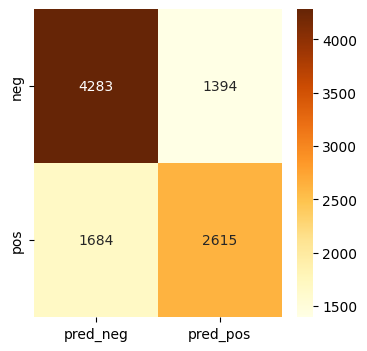

In [210]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

<font size=4>Correlation<font/>

I wanted to see if any features were highly correlated. And I could remove a feature if that was the case.

In [211]:
offers_classed.columns

Index(['person', 'time', 'offer_id', 'reward', 'difficulty', 'duration',
       'successful_offer', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational', 'age', 'became_member_on', 'income', 'female', 'male',
       'other'],
      dtype='object')

In [212]:
offers_classed.filter(['reward', 'difficulty', 'duration',
       'mobile', 'social', 'web', 'bogo', 'discount',
       'informational', 'age', 'became_member_on', 'income', 'female', 'male',
       'other']).corr().round(2)

,reward,difficulty,duration,mobile,social,web,bogo,discount,informational,age,became_member_on,income,female,male,other
reward,1.00,0.47,0.16,-0.08,0.29,-0.12,0.79,-0.29,-0.62,-0.00,-0.00,0.00,0.00,0.00,-0.00
difficulty,0.47,1.00,0.81,-0.74,-0.16,0.24,-0.03,0.60,-0.70,-0.00,-0.00,-0.00,-0.00,0.00,-0.00
duration,0.16,0.81,1.00,-0.53,-0.19,0.34,-0.18,0.74,-0.68,-0.00,-0.00,-0.00,-0.00,0.00,0.00
mobile,-0.08,-0.74,-0.53,1.00,0.41,-0.17,0.27,-0.41,0.17,-0.00,0.00,0.00,-0.00,0.00,-0.00
social,0.29,-0.16,-0.19,0.41,1.00,-0.41,0.25,-0.17,-0.10,-0.00,0.00,0.00,-0.00,0.00,-0.00
web,-0.12,0.24,0.34,-0.17,-0.41,1.00,-0.10,0.41,-0.37,-0.00,0.00,-0.00,-0.00,0.00,-0.00
bogo,0.79,-0.03,-0.18,0.27,0.25,-0.10,1.00,-0.67,-0.41,-0.00,-0.00,0.00,0.00,-0.00,-0.00
discount,-0.29,0.60,0.74,-0.41,-0.17,0.41,-0.67,1.00,-0.41,-0.00,0.00,-0.00,-0.00,0.00,-0.00
informational,-0.62,-0.70,-0.68,0.17,-0.10,-0.37,-0.41,-0.41,1.00,0.01,0.00,0.00,0.00,-0.00,0.00
age,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,1.00,-0.01,0.31,0.15,-0.15,0.00


In [213]:
#focusing on the customer data

In [214]:
offers_classed.filter(['age', 'became_member_on', 'income', 'female', 'male',
       'other']).corr().round(2)

,age,became_member_on,income,female,male,other
age,1.00,-0.01,0.31,0.15,-0.15,0.00
became_member_on,-0.01,1.00,-0.02,0.02,-0.02,0.01
income,0.31,-0.02,1.00,0.23,-0.22,-0.01
female,0.15,0.02,0.23,1.00,-0.97,-0.10
male,-0.15,-0.02,-0.22,-0.97,1.00,-0.14
other,0.00,0.01,-0.01,-0.10,-0.14,1.00


Income and age have a 0.31 correlation. I will try out dropping income to see if the model performs better. The reason I am exploring this option is an attempt to cut down on features. It is possible I could be over fitting the training data.

In [215]:
labels=offers_classed['successful_offer'].values

In [216]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on',   'female', 'male', 'other']).values

In [217]:
features_train, features_test, labels_train, labels_test=scale_split(features, labels)

In [218]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

removing 'income' didnt improve the model

              precision    recall  f1-score   support

unsuccessful     0.6955    0.7286    0.7116      5677
  successful     0.6175    0.5787    0.5975      4299

    accuracy                         0.6640      9976
   macro avg     0.6565    0.6536    0.6546      9976
weighted avg     0.6619    0.6640    0.6624      9976

CPU times: user 5.41 s, sys: 38.4 ms, total: 5.44 s
Wall time: 5.38 s


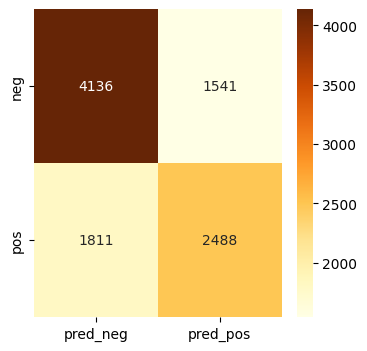

In [219]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

<font size=5>GridSearchCV<font/>

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65  
or  
https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn

First build a generic classifier and setup a parameter grid; random forests have many tunable parameters, which make it suitable for GridSearchCV (cross validation). The scorers dictionary can be used as the scoring argument in GridSearchCV. When multiple scores are passed, GridSearchCV.cv_results_ will return scoring metrics for each of the score types provided.


The classifier that I feel performed best with the default parameters was the RandomForestClassifier. It had a good F1 score for the positive class while also maintaining a F1 good score for the negative class. And overall its average weight F1 score was comfortably the best. 

While it didnt have the best recall for the positive cases I think by tuning the parameters to maximise this score I can obtain a model which suits my needs even more. I hope to have a model with a good recall for the positive classes while ensuring it still performs well across the other scores. Also, the RandomForestClassifier is an ideal candiate to perform GridSearchCV on due to the fact that it has many tuneable parameters.

Resetting the features and labels

In [220]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other']).values

labels=offers_classed['successful_offer'].values

features_train, features_test, labels_train, labels_test=scale_split(features, labels)

In [221]:
features_train[0]

array([0.2992993 , 0.6981982 , 1.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.51851852,
       0.29429429, 0.94844845, 1.        , 0.        , 0.        ])

In [222]:
#skf = StratifiedKFold(n_splits=10)
#setting to 4 temporarily
skf = StratifiedKFold(n_splits=10)

In [223]:
#param_grid={'criterion': ['gini', 'entropy'],
#            'max_depth': [5, 15, None],
#            'max_features': ['auto', 'sqrt','log2'],
#            'min_samples_leaf': [1, 3, 5, 10, 20],
#            'min_samples_split': [2, 3, 5, 10, 20],
#            'n_estimators': [10, 25, 50, 100, 300]}





#This took 4h 45min 57s for only 5 folds
#so would take 9.5 hours for 10 folds

In [224]:
param_grid={'criterion': ['entropy','gini'], 
            'max_depth': [20 , None],
            #'max_features': ['auto', 'sqrt','log2'],
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2, 10],
            'n_estimators': [ 100, 300]}

In [225]:
%%time

skf = StratifiedKFold(n_splits=10)

scores = ['accuracy', 'recall']
#scores = ['precision','f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(
        RandomForestClassifier(random_state=40), param_grid, n_jobs = 4, verbose=5, cv=skf, scoring=score # setting n_jobs to be 4 so i dont use all my cores at once
    )
    clf.fit(features_train, labels_train)

    print("The %s score for each hyper-parameter combination on the training set:\n" % score)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("\nBest parameters for {} found on training set are:\n{}\n".format(score, clf.best_params_))
    
    print("Classification report when hyper-params are optimised for :%s" % score)
    labels_true, labels_pred = labels_test, clf.predict(features_test)
    print(classification_report(labels_true, labels_pred, digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    print()



# Tuning hyper-parameters for accuracy
Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.700 total time=   9.4s
[CV 5/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.698 total time=   9.4s
[CV 2/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.704 total time=  29.4s


/home/benjamin/my_project_dir/my_project_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.709 total time=   9.6s
[CV 8/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.695 total time=   9.1s
[CV 1/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.700 total time=  30.2s
[CV 2/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.703 total time=   9.5s
[CV 7/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.700 total time=   8.8s
[CV 9/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.699 total time=   9.1s
[CV 3/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.712 total time=  29.2s


KeyboardInterrupt: 

In [226]:
#Enter the paremters from the grid search that maxmised recall for the positive class
def bestRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40, criterion= 'gini', max_depth= 20, n_estimators= 300)

    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    labels_pred=clf.predict(features_test)
   
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, labels_pred ,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
  
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, labels_pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

              precision    recall  f1-score   support

unsuccessful     0.7270    0.7728    0.7492      5677
  successful     0.6728    0.6169    0.6436      4299

    accuracy                         0.7056      9976
   macro avg     0.6999    0.6948    0.6964      9976
weighted avg     0.7037    0.7056    0.7037      9976



RandomForestClassifier(max_depth=20, n_estimators=300, random_state=40)

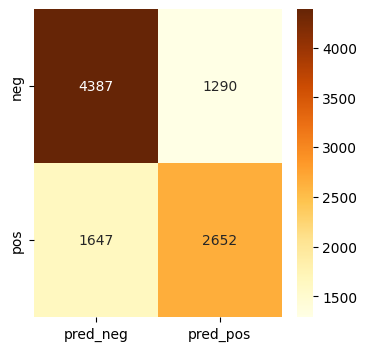

In [227]:
bestRandomForest(features_train, labels_train, features_test, labels_test)

my GridSearchCV

In [228]:
#Fitting the big one

#Fitting 5 folds for each of 2250 candidates, totalling 11250 fits
#CPU times: user 1min 55s, sys: 10.2 s, total: 2min 6s
#Wall time: 4h 45min 57s
#GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
#             estimator=RandomForestClassifier(random_state=40), n_jobs=-1,
#             param_grid={'criterion': ['gini', 'entropy'],
#                         'max_depth': [5, 15, None],
#                         'max_features': ['auto', 'sqrt', 'log2'],
#                         'min_samples_leaf': [1, 3, 5, 10, 20],
#                         'min_samples_split': [2, 3, 5, 10, 20],
#                         'n_estimators': [10, 25, 50, 100, 300]},
#             refit='recall_binary', verbose=5)

#results for grid_search.best_params_
#{'criterion': 'entropy',
# 'max_depth': None,
# 'max_features': 'auto',
# 'min_samples_leaf': 1,
# 'min_samples_split': 20,
# 'n_estimators': 300}

<font size=5>Refinement with new features<font>

In [243]:
offers_classed_nf=pd.read_pickle("final_table_nf.pkl")

In [244]:
offers_classed_nf.head()

,person,time,offer_id,reward,difficulty,duration,successful_offer,mobile,social,web,...,became_member_on,income,female,male,other,total_spend,transaction,completed,received,viewed
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,3.0,1.0,1.0,1.0,0.0,...,1492732800000000000,72000.0,False,True,False,0.00,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,0.0,0.0,4.0,1.0,1.0,0.0,1.0,...,1492732800000000000,72000.0,False,True,False,22.16,1,0,2,1
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,0.0,1.0,1.0,1.0,...,1492732800000000000,72000.0,False,True,False,22.16,1,0,3,2
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,0.0,1.0,1.0,1.0,...,1492732800000000000,72000.0,False,True,False,30.73,2,1,4,3
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,0.0,1.0,0.0,1.0,...,1492732800000000000,72000.0,False,True,False,58.40,4,2,5,4


In [245]:
labels=offers_classed_nf['successful_offer'].values
print(len(labels))

66501


In [246]:
features_nf = offers_classed_nf.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other','total_spend','transaction','completed','received','viewed']).values
#,'transaction','completed','received','viewed'
print(len(features))

66501


In [247]:
features_train, features_test, labels_train, labels_test=scale_split(features_nf, labels)

In [248]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf


              precision    recall  f1-score   support

unsuccessful     0.7214    0.7835    0.7512      5677
  successful     0.6774    0.6004    0.6366      4299

    accuracy                         0.7046      9976
   macro avg     0.6994    0.6919    0.6939      9976
weighted avg     0.7024    0.7046    0.7018      9976

CPU times: user 7.03 s, sys: 187 ms, total: 7.22 s
Wall time: 7.12 s


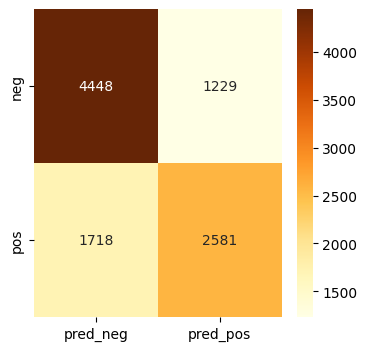

In [249]:

%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

In [250]:
features_nf_df=offers_classed_nf.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income',   'female', 'male', 'other','total_spend','transaction','completed','received','viewed'])

In [237]:
dict = {}
for A, B in zip(features_nf_df.columns.values, clf.feature_importances_):
    dict[A] = B

I can see that my new features (total_spend, transaction, completed, viewed, recieved) have a pretty decent importance ratio.

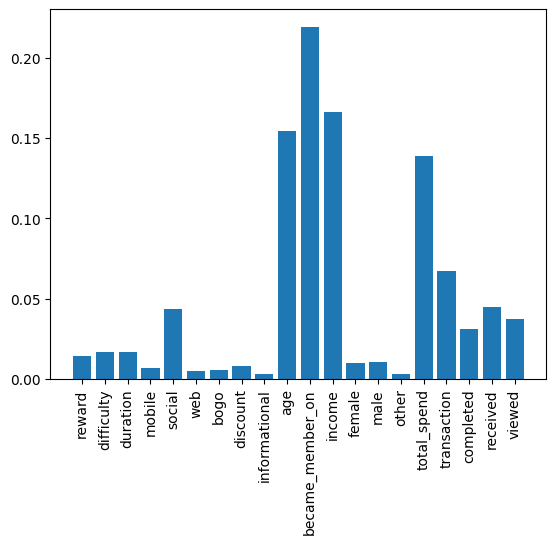

In [251]:
names = list(dict.keys())
values = list(dict.values())

plt.bar(range(len(dict)), values, tick_label=names)
plt.xticks(rotation=90)
plt.show()

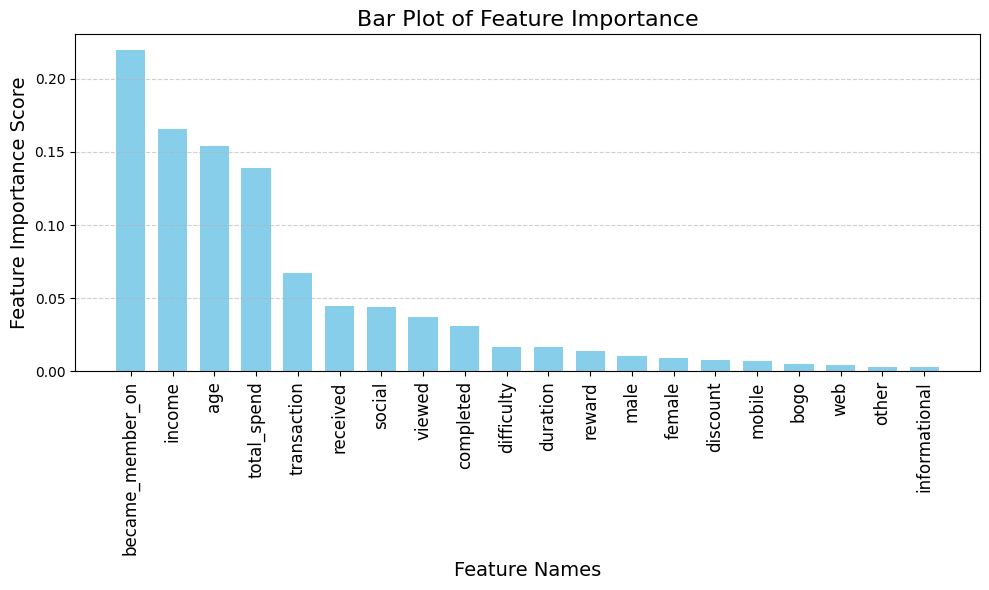

In [252]:

# Assuming 'dict' is already defined
names = list(dict.keys())
values = list(dict.values())

# Sort the values in descending order along with their corresponding names
sorted_names_values = sorted(zip(names, values), key=lambda x: x[1], reverse=True)
sorted_names, sorted_values = zip(*sorted_names_values)

# Create a bar plot with improved aesthetics
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(sorted_values)), sorted_values, tick_label=sorted_names, color='skyblue', width=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# Add labels and title
ax.set_xlabel('Feature Names', fontsize=14)
ax.set_ylabel('Feature Importance Score', fontsize=14)
ax.set_title('Bar Plot of Feature Importance', fontsize=16)

# Add gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


PCA with new features

In [254]:
scaler=QuantileTransformer()

In [260]:
features_scaled=scaler.fit_transform(features_nf)

In [261]:
features_scaled[0]

array([0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.13563564,
       0.43543544, 0.64164164, 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [262]:
len(features_scaled)

66501

In [266]:
pca = PCA(n_components=20)
pca.fit(np.transpose(features_scaled))

PCA(n_components=20)

In [267]:
print(pca.explained_variance_ratio_)


[2.35060809e-01 1.72141168e-01 1.44845570e-01 1.23632256e-01
 1.00377651e-01 7.06957465e-02 3.33514980e-02 2.64825163e-02
 1.88713766e-02 1.80452307e-02 1.59713935e-02 1.34125957e-02
 1.05056518e-02 5.56967212e-03 4.08760147e-03 3.72036118e-03
 2.11447794e-03 1.11442458e-03 2.97242693e-32 1.54764964e-32]


<function matplotlib.pyplot.show(close=None, block=None)>

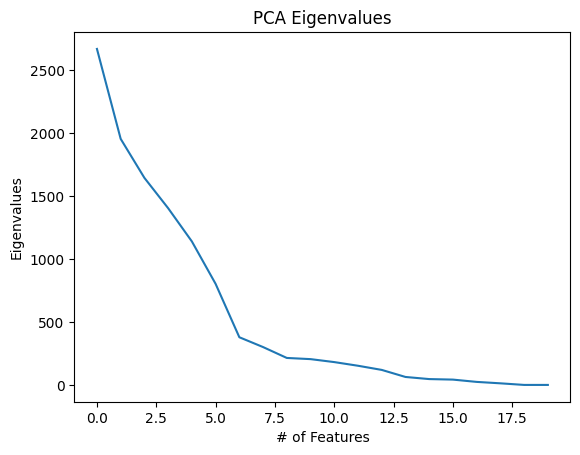

In [268]:

plt.title('PCA Eigenvalues')
plt.ylabel('Eigenvalues')
plt.xlabel('# of Features')
plt.plot(pca.explained_variance_)
plt.show

The elbow is after 6 features

<function matplotlib.pyplot.show(close=None, block=None)>

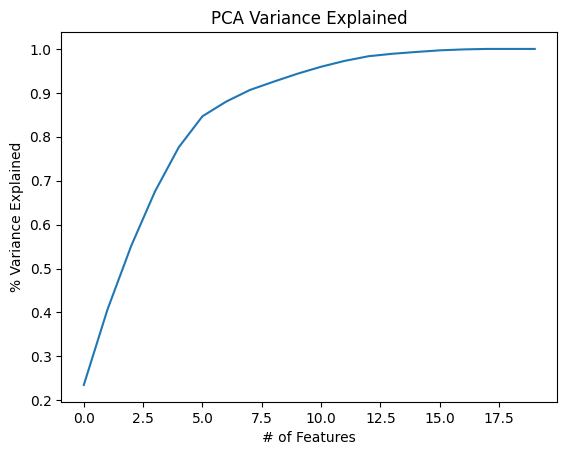

In [269]:
variance=pca.explained_variance_ratio_
var=np.cumsum(pca.explained_variance_ratio_)

plt.title('PCA Variance Explained')
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.plot(var)
plt.show

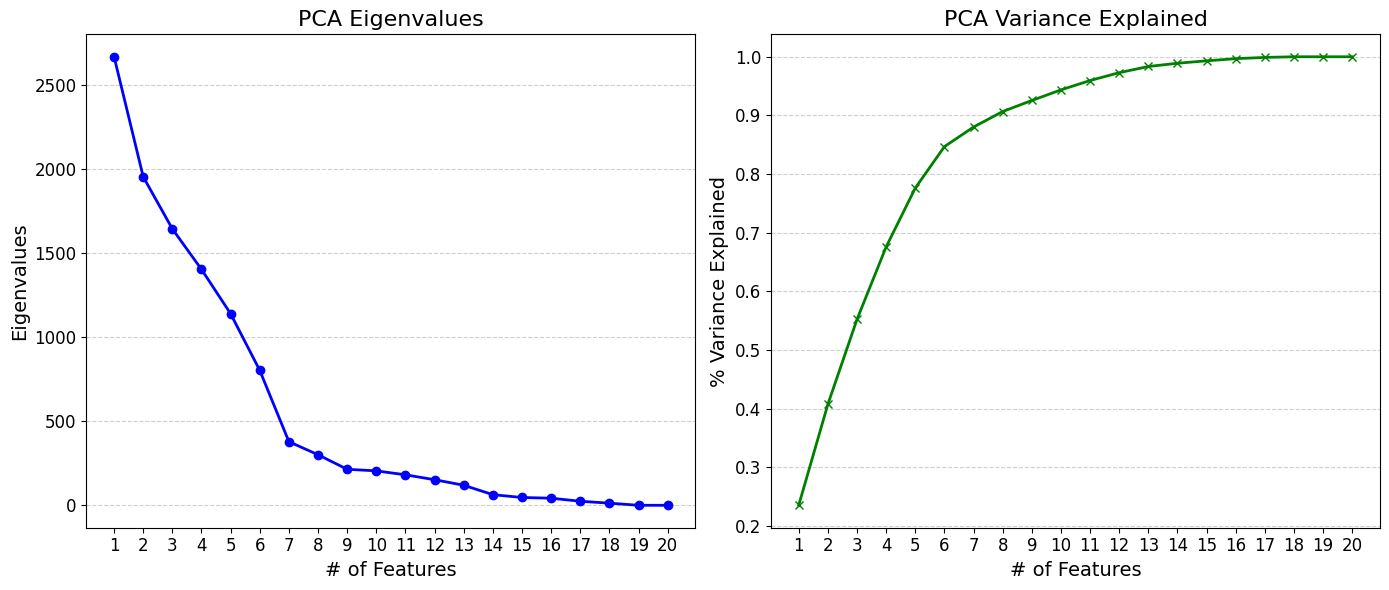

In [270]:


# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Eigenvalues
ax1.plot(pca.explained_variance_, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
ax1.set_title('PCA Eigenvalues', fontsize=16)
ax1.set_xlabel('# of Features', fontsize=14)
ax1.set_ylabel('Eigenvalues', fontsize=14)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', labelsize=12)

# Adjust x-axis labels to start from 1 instead of 0
ax1.set_xticks(np.arange(0, len(pca.explained_variance_)))  # Internal ticks still start from 0
ax1.set_xticklabels(np.arange(1, len(pca.explained_variance_) + 1))  # Labels start from 1

# Plot Variance Explained
variance = pca.explained_variance_ratio_
var = np.cumsum(variance)

ax2.plot(var, color='green', marker='x', linestyle='-', linewidth=2, markersize=6)
ax2.set_title('PCA Variance Explained', fontsize=16)
ax2.set_xlabel('# of Features', fontsize=14)
ax2.set_ylabel('% Variance Explained', fontsize=14)
ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
ax2.tick_params(axis='both', labelsize=12)

# Adjust x-axis labels to start from 1 instead of 0
ax2.set_xticks(np.arange(0, len(var)))  # Internal ticks still start from 0
ax2.set_xticklabels(np.arange(1, len(var) + 1))  # Labels start from 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [271]:
print("the first 6 pca components represents {:0.2f} of the variance".format(np.cumsum(pca.explained_variance_ratio_)[6]))


the first 6 pca components represents 0.88 of the variance


In [272]:
pca = PCA(n_components=7)
pca.fit(np.transpose(features_scaled))

PCA(n_components=7)

In [273]:
pca_features=np.transpose(pca.components_)

In [274]:
features_train, features_test, labels_train, labels_test = train_test_split(pca_features, labels, train_size=0.85, random_state=40)

In [275]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

              precision    recall  f1-score   support

unsuccessful     0.6949    0.7525    0.7225      5677
  successful     0.6330    0.5636    0.5963      4299

    accuracy                         0.6711      9976
   macro avg     0.6639    0.6581    0.6594      9976
weighted avg     0.6682    0.6711    0.6681      9976

CPU times: user 17.8 s, sys: 38.3 ms, total: 17.8 s
Wall time: 17.7 s


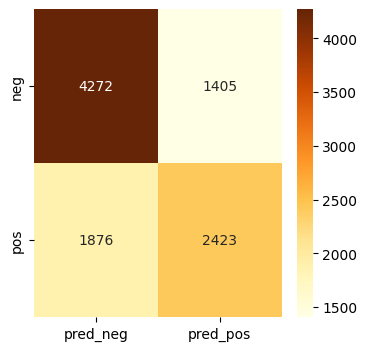

In [276]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)


Again, PCA reduction does not show an apparent improvment using the default decision tree parameters.

<font size=4>Correlations<font>

In [85]:
offers_classed_nf.filter(['age', 'became_member_on', 'income', 'female', 'male',
       'other','total_spend','transaction','completed','received','viewed']).corr().round(2)

,age,became_member_on,income,female,male,other,total_spend,transaction,completed,received,viewed
age,1.00,-0.01,0.31,0.15,-0.15,0.00,0.06,-0.09,0.06,-0.00,0.01
became_member_on,-0.01,1.00,-0.02,0.02,-0.02,0.01,-0.11,-0.25,-0.13,-0.00,-0.01
income,0.31,-0.02,1.00,0.23,-0.22,-0.01,0.21,-0.15,0.15,-0.00,0.03
female,0.15,0.02,0.23,1.00,-0.97,-0.10,0.10,-0.03,0.10,-0.00,0.01
male,-0.15,-0.02,-0.22,-0.97,1.00,-0.14,-0.10,0.03,-0.11,0.00,-0.01
other,0.00,0.01,-0.01,-0.10,-0.14,1.00,0.00,0.00,0.01,-0.01,0.01
total_spend,0.06,-0.11,0.21,0.10,-0.10,0.00,1.00,0.52,0.59,0.38,0.41
transaction,-0.09,-0.25,-0.15,-0.03,0.03,0.00,0.52,1.00,0.63,0.60,0.59
completed,0.06,-0.13,0.15,0.10,-0.11,0.01,0.59,0.63,1.00,0.61,0.63
received,-0.00,-0.00,-0.00,-0.00,0.00,-0.01,0.38,0.60,0.61,1.00,0.86


Income is correlated somewhat with total_spend as I would expect.

honing in on my the new features

In [86]:
display(offers_classed_nf.filter(['total_spend','transaction','completed','received','viewed']).corr().round(2))
display(offers_classed_nf.filter(['total_spend','transaction','completed','received','viewed']).corr().round(2).sum())

,total_spend,transaction,completed,received,viewed
total_spend,1.00,0.52,0.59,0.38,0.41
transaction,0.52,1.00,0.63,0.60,0.59
completed,0.59,0.63,1.00,0.61,0.63
received,0.38,0.60,0.61,1.00,0.86
viewed,0.41,0.59,0.63,0.86,1.00


total_spend    2.90
transaction    3.34
completed      3.46
received       3.45
viewed         3.49
dtype: float64

I see some pretty strong correlations between the events and the total spend. I tested out some models with some of the new features removed. I saw a slight degradation with 'viewed' or 'received' were removed. 

I can see 'total_spent' is quite highly correlated with transactions and completed offers (as expected). It is slightly less correlated with received and viewed offers, but still signifcantly correlated (as expected).

I will test out a default random forest with the events (transaction, completed, received, viewed) removed.  
I can see that viewed is particularly highly correlated with completed and received (the highest two in the grid). So I will leave in viewed and remove completed and received.

I will remove the new features 'completed' & 'viewed' in order to try and stem the risk of overfitting my model

In [277]:
features_nf = offers_classed_nf.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','received']).values
#'completed','viewed'
print(len(features))

66501


In [278]:
features_train, features_test, labels_train, labels_test=scale_split(features_nf, labels)
features_train[31]

array([1.        , 0.6986987 , 0.5955956 , 1.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.53503504,
       0.17584251, 0.        , 0.        , 1.        , 0.        ,
       0.59525109, 0.92992993, 0.9014014 ])

In [279]:
def classifyRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40)
    
    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    pred=clf.predict(features_test)
    
    #evaluate how good the model did at predicting the true teting labels
    print(classification_report(labels_test, pred,digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

I can see a slight improvment in the weighted f1-score  
I can see a slight improvement in the overall accuracy 

              precision    recall  f1-score   support

unsuccessful     0.7247    0.7884    0.7553      5677
  successful     0.6839    0.6046    0.6418      4299

    accuracy                         0.7092      9976
   macro avg     0.7043    0.6965    0.6985      9976
weighted avg     0.7072    0.7092    0.7064      9976

CPU times: user 7.36 s, sys: 57.9 ms, total: 7.42 s
Wall time: 7.32 s


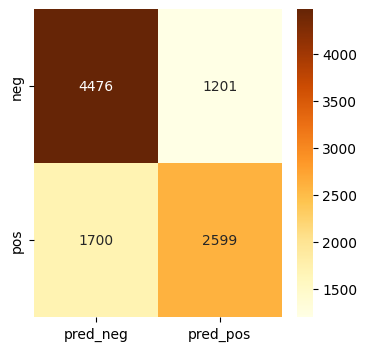

In [280]:
%%time
clf = classifyRandomForest(features_train, labels_train, features_test, labels_test)

<font size=4>GridSearchCV with new features<font/>

In [281]:
features_nf = offers_classed_nf.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','received']).values

labels=offers_classed_nf['successful_offer'].values

In [92]:
features_train, features_test, labels_train, labels_test=scale_split(features_nf, labels)

In [282]:
features_train[0]

array([0.2987988 , 0.6986987 , 1.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.51251251,
       0.30630631, 0.95045045, 1.        , 0.        , 0.        ,
       0.73562948, 0.43143143, 0.55055055])

In [283]:
skf = StratifiedKFold(n_splits=10)

In [284]:


param_grid={'criterion': ['entropy','gini'], 
            'max_depth': [20 , None],
            #'max_features': ['auto', 'sqrt','log2'], # the default auto has proved best
            'min_samples_leaf': [1, 5, 10],
            'min_samples_split': [2, 10],
            'n_estimators': [ 100, 300]}

In [285]:
%%time

scores = ['accuracy', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(
        RandomForestClassifier(random_state=40), param_grid, n_jobs = -1, verbose=5, cv=skf, scoring=score #scoring='%s_macro' % score
    )
    clf.fit(features_train, labels_train)

    print("The %s score for each hyper-parameter combination on the training set:\n" % score)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("\nBest parameters for {} found on training set are:\n{}\n".format(score, clf.best_params_))
    
    print("Classification report when hyper-params are optimised for : %s" % score)
    labels_true, labels_pred = labels_test, clf.predict(features_test)
    print(classification_report(labels_true, labels_pred, digits=4, target_names=['unsuccessful','successful'],output_dict=False))
    print()



# Tuning hyper-parameters for accuracy
Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 5/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.709 total time=  14.9s
[CV 2/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.716 total time=  50.5s


/home/benjamin/my_project_dir/my_project_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 6/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.704 total time=  15.1s
[CV 3/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.717 total time=  51.1s
[CV 1/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.715 total time=  15.3s
[CV 5/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.706 total time=  51.4s
[CV 8/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.702 total time=  14.5s
[CV 10/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.716 total time=  15.6s
[CV 8/10] END criterion=entropy, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.702 total time=  54.2s
[CV 7/10] END criterion=entropy, 

KeyboardInterrupt: 

In [286]:
#Enter the paremters from the grid search that maxmised recall for the positive class

                
def bestRandomForest(features_train, labels_train, features_test, labels_test):
    
    #create the classifer
    clf = RandomForestClassifier(random_state=40, criterion= 'gini', max_depth = 20, n_estimators= 300)

    #fit the training data
    clf = clf.fit(features_train, labels_train)
    
    #predict the testing labels using the testing features
    labels_pred=clf.predict(features_test)
 
    #labels_true, labels_pred = labels_test, clf.predict(features_test)
    print(classification_report(labels_test, labels_pred, digits=4, target_names=['unsuccessful','successful'],output_dict=False))

  
    #printing the confusion matrix
    con_mat=pd.DataFrame(confusion_matrix(labels_test, labels_pred),  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    plt.figure(figsize = (4,4))
    sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

    return clf

In [289]:

def bestRandomForest(features_train, labels_train, features_test, labels_test):
    #create the classifer
    clf = RandomForestClassifier(random_state=40, criterion= 'gini', max_depth = 20, n_estimators= 300)
    
    # Fit the training data
    clf.fit(features_train, labels_train)
    
    # Predict the testing labels using the testing features
    pred = clf.predict(features_test)
    
    # Print the classification report
    print(classification_report(labels_test, pred, digits=4, target_names=['unsuccessful', 'successful'], output_dict=False))
    
    # Print the confusion matrix
    con_mat = pd.DataFrame(confusion_matrix(labels_test, pred), columns=['Predicted Negative', 'Predicted Positive'], index=['Negative', 'Positive'])
    
    plt.figure(figsize=(5, 5))  # Adjusted figure size
    sn.heatmap(con_mat, annot=True, cmap='YlOrBr', fmt='g',
               annot_kws={'size': 16},  # Increase annotation size
               xticklabels=['Negative', 'Positive'],  # Custom x-axis labels
               yticklabels=['Negative', 'Positive'],  # Custom y-axis labels
               cbar=True)  # Optional: Remove color bar for simplicity
    
    # Adjust label sizes
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return clf


              precision    recall  f1-score   support

unsuccessful     0.7289    0.7914    0.7589      5677
  successful     0.6894    0.6113    0.6480      4299

    accuracy                         0.7138      9976
   macro avg     0.7092    0.7014    0.7034      9976
weighted avg     0.7119    0.7138    0.7111      9976



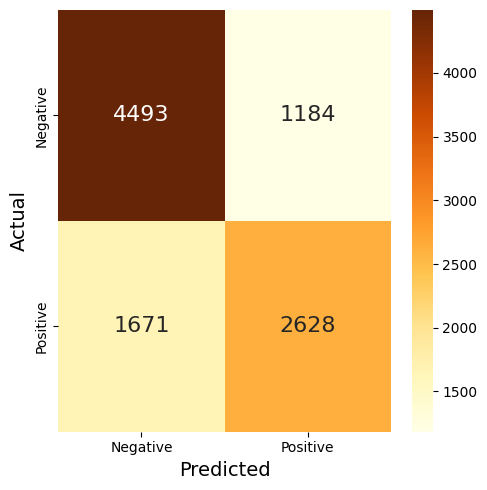

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=40)

In [290]:
bestRandomForest(features_train, labels_train, features_test, labels_test)